In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# SPECIFY dataset name, number (add entry to all_experiments.py)

In [2]:
project_directory = "Vue4Logs"

In [3]:
cd /content/gdrive/My Drive/{project_directory}/Thaler2017

/content/gdrive/My Drive/Vue4Logs/Thaler2017


In [4]:
!pip3 install -r requirements.txt

In [5]:
dataset = "apache"
dataset_number = 18
experiment_type = 'test'

In [6]:
# change dataset/main_dataset_folder name in fiel paths
!cp /content/gdrive/My\ Drive/{project_directory}/Datasets_TB/as_log_files/{dataset}/{dataset}.log data
!cp /content/gdrive/My\ Drive/{project_directory}/Datasets_TB/ground_truth/{dataset}/{dataset}.log data/test
!cp /content/gdrive/My\ Drive/{project_directory}/Datasets_TB/ids_files/{dataset}/{dataset}.ids data

In [7]:
# display ipython notebook full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# autoreloading https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [8]:
from library.all_imports import * 
from library.helpers import save_to_json, load_from_json, save_to_csv, create_if_not_exists, get_N_HexCol, multiprocess_file
from library.plotting import plot

assert tf.__version__=="1.0.1" # the tensorflow library we used 
tf.set_random_seed(0)
np.random.seed(0) # fix random seed for reproducability
tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:455: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:456: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:457: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or 

Using TensorFlow version 1.0.1


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# 0 Hyperparameter

In [9]:
from library.all_experiments import * # experiments are defined here

def lib_name(exp_nr):
    if exp_nr in EXPERIMENT_LIB_MAPPING:
        return "data_generation.%s"%EXPERIMENT_LIB_MAPPING[exp_nr]
    else:
        return "data_generation.%s"%ALL_EXPERIMENTS[exp_nr] 
    
experiment_nr = dataset_number # 6 (unix forensic), 11 (bgl), 13 (spirit2) 7-android 8-apache --------------------commented other experiments----------
EXPERIMENT_ID = ALL_EXPERIMENTS[experiment_nr] # choose data - it will be automatically generated
print("Running experiment: %s"%EXPERIMENT_ID)
EXPERIMENT_SPLIT_TOKEN = SPLIT_TOKEN[experiment_nr] if (experiment_nr in SPLIT_TOKEN.keys()) else SPLIT_TOKEN["default"]

unknown_token = g.unknown_token = "UNKNOWN_TOKEN"
logline_start_token = g.logline_start_token = "LOG_START"
logline_end_token = g.logline_end_token= "LOG_END"
pad_token = g.pad_token = "PAD_TOKEN"
g.vocabulary_max_lines = -1 # -1 means unlimited
g.max_line_len = 200

# define names
run_tag = "m-pn"
model_name = "rnn-autoencoder"

# clustering 
cluster_alg="birch" # alternatives:  birch hierarch dbscan  
# fold_times = 10  ------------no folds--------------------

# create experiment directories
result_dir = "results"
experiment_dir = "%.2d_%s"%(experiment_nr,EXPERIMENT_ID)
experiment_outdir = join_path(result_dir, experiment_dir ,  now_str )
checkpoint_path = join_path(experiment_dir , "graph", run_tag)
graph_dir = join_path(experiment_outdir,"graph",run_tag)

create_if_not_exists(checkpoint_path)
create_if_not_exists(graph_dir)

# data files

datafile = g.datafile =  "data/%s.log"%EXPERIMENT_ID
labels_true_file = "data/%s.ids"%EXPERIMENT_ID
processed_datafile = join_path(result_dir, experiment_dir,"%s_log.processed"%EXPERIMENT_ID)
test_data_processed = join_path(result_dir, experiment_dir,"%s_test_log.processed"%EXPERIMENT_ID) #--------includes test input to the model--------
VOCABULARY_FILE = g.VOCABULARY_FILE = join_path(result_dir, experiment_dir, "vocabulary.json")
HYPERPARAMETERS_FILE = join_path(experiment_outdir, "hyperparams.json")
CLUSTERING_RESULTS_FILE = join_path(experiment_outdir, "clustering_results.csv")
learned_weights_file = join_path(experiment_outdir,"learned_weights.csv")
DATASET_STATS_FILE = join_path(result_dir, experiment_dir, "dataset_statistics.json")                                

#
g.REGENERATE_VOCABULARY_FILES = True    
g.REPROCESS_TRAININGS_DATA  = True
learn_model = True

Running experiment: apache


# Generate vocabulary

To generate our vocabulary, we perform the following steps:
* tokenize the log lines of the data file
* create Vocabulary from tokenized loglines, count word frequencies 
* create index_to_word and word_to_index dictionary
* replace unknown words with an UNK token (not relevant for us now)

If you need to see which steps are taken, have a look at  library.vocabulary.py


In [10]:
g.WORD_TO_INDEX_FILE = join_path(result_dir, experiment_dir, "word_to_index.json")
g.INDEX_TO_WORD_FILE = join_path(result_dir, experiment_dir, "index_to_word.json")
g.TOKENIZED_LOGLINES_FILE = join_path(result_dir, experiment_dir, "tokenized_loglines.json")
g.SPLIT_TOKEN = EXPERIMENT_SPLIT_TOKEN

# g.SPLIT_TOKEN = ['"']
from library.vocabulary import *
print("Dataset fully loaded")       

Loaded 56482 loglines
Tokenizing 56482 lines... 
Estimated time for tokenization ~ 0.01 (in min)
Tokenized logfile.
Created index_to_word and word_to_index dictionary. 
Saved to json: results/18_apache/vocabulary.json.
Saved to json: results/18_apache/tokenized_loglines.json.
Saved to json: results/18_apache/index_to_word.json.
Saved to json: results/18_apache/word_to_index.json.
Tokenized loglines samples:
	['LOG_START', '', '[', 'thu', 'jun', '09', '06', ':', '07', ':', '04', '2005', ']', '', '', '[', 'notice', ']', '', 'ldap', ':', '', 'built', 'with', 'openldap', 'ldap', 'sdk\n', 'LOG_END']

	['LOG_START', '', '[', 'thu', 'jun', '09', '06', ':', '07', ':', '04', '2005', ']', '', '', '[', 'notice', ']', '', 'ldap', ':', '', 'ssl', 'support', 'unavailable\n', 'LOG_END']

	['LOG_START', '', '[', 'thu', 'jun', '09', '06', ':', '07', ':', '04', '2005', ']', '', '', '[', 'notice', ']', '', 'suexec', 'mechanism', 'enabled', '', '(', 'wrapper', ':', '', '', '/', 'usr', '/', 'sbin', '/', 's

# Datset statistics

sorted words
('', '/', ':', '[', ']', '.', 'error', '2005', 'client', 'var', 'www', 'not', 'html', 'file', 'does', 'exist', '2006', 'nov', '_', 'init', 'found', 'notice', '(', ')', 'child', 'in', 'jan', 'workerenv', 'sun', 'mon', '20', '04', 'feb', '21', 'jk2', 'tue', '03', 'sat', 'to', 'script', '\n', 'or', 'unable', '16', 'mod', '17', 'directory', 'index', 'forbidden', 'by', 'rule', 'thu', 'scoreboard', 'slot', '10', '05', 'dec', '09', '12', '19', 'ok', 'etc', 'httpd', 'conf', 'workers2', 'properties\n', 'wed', 'jk', '11', '22', '01', '08', '14', '23', 'awstats', '28', '06', '18', '00', '-', '02', '15', 'stat\n', 'state', '24', 'fri', '29', '13', '25', '07', 'cgi', 'bin', '37', 'blog\n', 'stat', 'jul', 'pl\n', '30', '27', '40', '31', '48', 'jun', '218', '53', '46', '52', '26', '35', '61', '54', '36', '55', '59', '41', '45', '34', '64', '43', '44', '66', '38', '50', '42', '1', '56', '39', 'sep', '4\n', '47', 'blogs\n', '58', '57', '6\n', '32', '51', '33', 'drupal\n', 'phpgroupware\n',

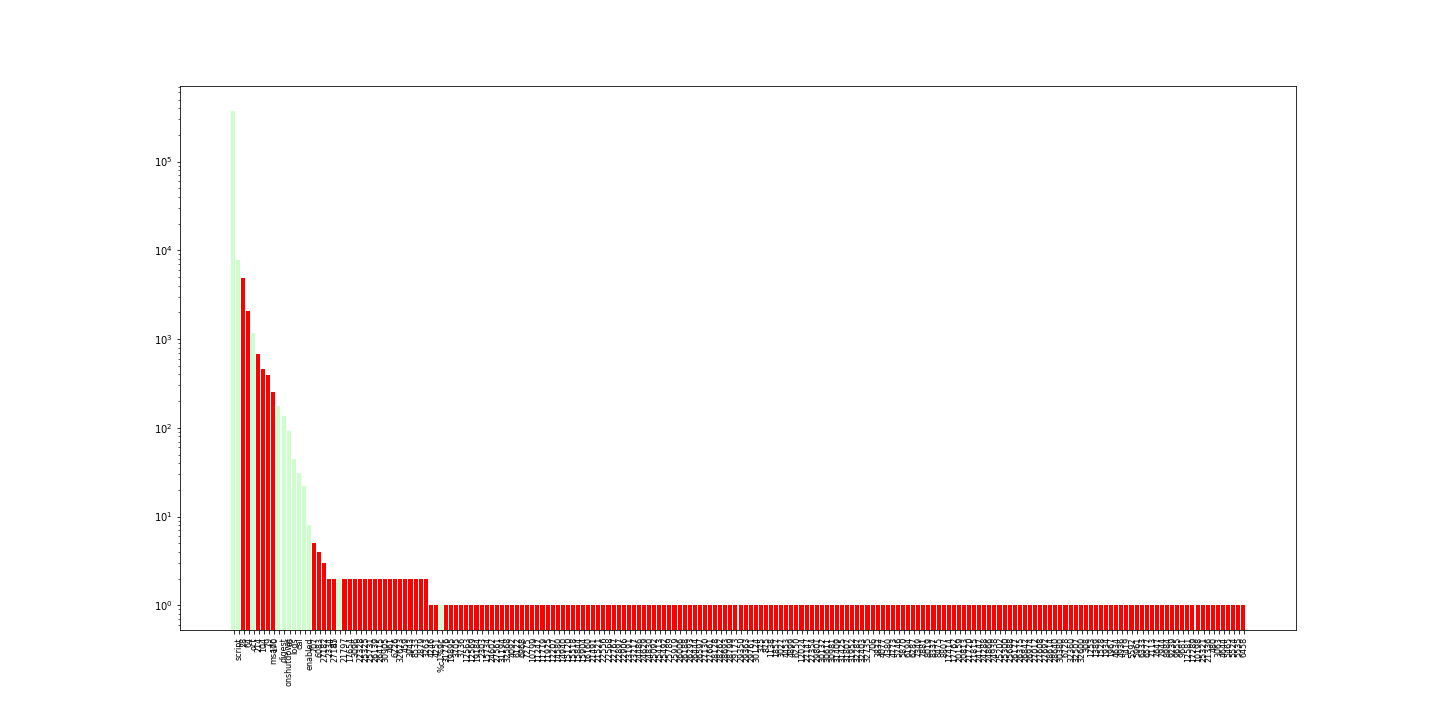

In [11]:
#for w in sorted(word_frequencies.iteritems(), key= lambda x:x[1], reverse=True):
del word_frequencies["LOG_START"]
del word_frequencies["LOG_END"]
#    print(w)

words,frequencies = zip(*sorted(word_frequencies.items(), key= lambda x:x[1], reverse=True))
print("sorted words")
print(words[0:200])

total_words = len(words)
stratify_parts = 200

stratum_length = total_words/stratify_parts

indices = []

for i in range(stratify_parts):    
    strat_start = i* stratum_length
    strat_end = (i+1) * stratum_length -1   
    new_index = np.random.randint(strat_start, strat_end)
#    print(strat_start, strat_end, new_index)
    indices.append(new_index)
    
words = np.array(words)[indices]
frequencies = np.array(frequencies)[indices]

print("Sorted words.")

words = [str(w) for w in words]
colors = []
for w in words:
    if w.isdigit():
        colors.append("r")# "#ffcccc" light red      
    else:
        colors.append("#ccffcc") #light green
print("Defined colors")
        
cluster_plot_file = join_path(result_dir,experiment_dir, "dataset_stats.png")
figure_size=(20,10) 
fig = plt.figure(figsize=figure_size)

index = np.arange(len(words))
bar_width = 0.35


ax1 = fig.add_subplot(111)
ax1.bar(index, frequencies,  color=colors)
ax1.set_yscale('log')
plt.xticks(index + bar_width / 2, (words), rotation=90, fontsize = 8)
plt.savefig(cluster_plot_file)
plt.close()

Image(filename=cluster_plot_file) 

# Average LogLine Length

In [12]:
line_lengths = []
for logline in tokenized_loglines: 
    line_lengths.append(len(logline))

In [13]:
np.average(line_lengths)

39.76070252469813

# 1.3 Process trainingsdata

In [14]:
# Create the training data
if g.REPROCESS_TRAININGS_DATA: 
    X_train = np.asarray([[word_to_index[w] for w in logline] for logline in tokenized_loglines])
    maximum_sequence_length =-1
    train_numbers_file = open(processed_datafile,"w")
    one_percent = len(X_train)/100
    for i, logline_as_word_id_sequence in enumerate(X_train):
        if i%one_percent==0: print("Written line %i"%i)
        #print ",".join(line)

        reversed_seq = list(reversed(logline_as_word_id_sequence))
        # add sequence length to example

        sequence_length = str(len(logline_as_word_id_sequence))
        if len(logline_as_word_id_sequence)>maximum_sequence_length: maximum_sequence_length=len(logline_as_word_id_sequence) # find maximum sequence length
        word_id_seq = ",".join(map(str,logline_as_word_id_sequence)) # encoder input: 1,2,3 
        word_id_seq_reversed = ",".join(map(str,reversed_seq)) # decoder input: 3,2,1 
        target_seq = ",".join(map(str, reversed_seq[1:]+[PAD_ID])) # decoder target: 2,1,PAD 

        signature_id =  5 # experiment_lib.extract_pattern_id(loglines[i]) -------- not relevent---------------
        assert not signature_id==0,"Each log line has to be associated to one signature, none for (%s). Check extract_pattern_id method."%loglines[i]
        # write      
        train_numbers_file.write("%s|%s|%s|%s|%s\n"%(signature_id, sequence_length, word_id_seq,word_id_seq_reversed,target_seq))

    train_numbers_file.close()

    ##############

    #### tokenizing test data part
    tokenized_test_loglines = []

    test_loglines = list(open("data/test/%s.log"%EXPERIMENT_ID, 'r'))
    print("Loaded %i test_loglines"%len(test_loglines))
    total_lines = len(test_loglines) if g.vocabulary_max_lines==-1 else g.vocabulary_max_lines
    print("Tokenizing test %i lines... "%total_lines)
    print("test_loglines",len(test_loglines))
    
    for i, test_logline in enumerate(test_loglines):
        
        test_logline = test_logline.lower()
        
        for char in g.SPLIT_TOKEN:
            test_logline = test_logline.replace(char, ' ' + char + ' ')
        
        tokenized_test_logline = test_logline.split(" ")[0:200] #nltk.word_tokenize(logline)
        
        tokenized_test_logline = [g.logline_start_token] + tokenized_test_logline + [g.logline_end_token]
        
        tokenized_test_loglines.append(tokenized_test_logline)

        if g.vocabulary_max_lines>0 and i>g.vocabulary_max_lines:
            break
    
    for i, test_logline in enumerate(tokenized_test_loglines):
        tokenized_test_loglines[i] = [w if w in word_to_index else g.unknown_token for w in test_logline]

    # for i in tokenized_test_loglines:
    #     print(i)
    print ("Tokenized logfile.")
    #### tokeninzing test data part finish

    array_to_xtrain = []

    X_test = np.asarray([[word_to_index[w] for w in logline] for logline in tokenized_test_loglines])
    ### put UNK into words in test that were not in train
    # for logline in tokenized_test_loglines:
    #   numbered_line = []
    #   for w in logline:
    #     if w in word_to_index:
    #       numbered_line.append(word_to_index[w])
    #     else:
    #       numbered_line.append(word_to_index["UNK_TOKEN"])
    #   array_to_xtrain.append(numbered_line)
    # X_test = np.asarray(array_to_xtrain)
    #### put UNK into words in test that were not in train FINISHED

    maximum_sequence_length =-1
    test_numbers_file = open(test_data_processed,"w")
    one_percent = len(X_test)/100

    for i, test_logline_as_word_id_sequence in enumerate(X_test):
        if i%one_percent==0: print("Written line %i"%i)
        #print ",".join(line)

        reversed_seq = list(reversed(test_logline_as_word_id_sequence))
        # add sequence length to example

        sequence_length = str(len(test_logline_as_word_id_sequence))
        if len(test_logline_as_word_id_sequence)>maximum_sequence_length: maximum_sequence_length=len(test_logline_as_word_id_sequence) # find maximum sequence length
        word_id_seq = ",".join(map(str,test_logline_as_word_id_sequence)) # encoder input: 1,2,3 
        word_id_seq_reversed = ",".join(map(str,reversed_seq)) # decoder input: 3,2,1 
        target_seq = ",".join(map(str, reversed_seq[1:]+[PAD_ID])) # decoder target: 2,1,PAD 

        # signature_id = experiment_lib.extract_pattern_id(loglines[i]) #######
        signature_id = 5

        assert not signature_id==0,"Each log line has to be associated to one signature, none for (%s). Check extract_pattern_id method."%loglines[i]
        # write      
        test_numbers_file.write("%s|%s|%s|%s|%s\n"%(signature_id, sequence_length, word_id_seq,word_id_seq_reversed,target_seq))
    test_numbers_file.close()
    ##############
else:
    X_train = np.asarray([[word_to_index[w] for w in logline] for logline in tokenized_loglines])
    print("Trainingsdata has already been processed")

if not os.path.exists(labels_true_file):
    os.system("python3 create_true_labels.py -en %s"%EXPERIMENT_ID)

Written line 0
Loaded 2000 test_loglines
Tokenizing test 2000 lines... 
test_loglines 2000
Tokenized logfile.
Written line 0
Written line 20
Written line 40
Written line 60
Written line 80
Written line 100
Written line 120
Written line 140
Written line 160
Written line 180
Written line 200
Written line 220
Written line 240
Written line 260
Written line 280
Written line 300
Written line 320
Written line 340
Written line 360
Written line 380
Written line 400
Written line 420
Written line 440
Written line 460
Written line 480
Written line 500
Written line 520
Written line 540
Written line 560
Written line 580
Written line 600
Written line 620
Written line 640
Written line 660
Written line 680
Written line 700
Written line 720
Written line 740
Written line 760
Written line 780
Written line 800
Written line 820
Written line 840
Written line 860
Written line 880
Written line 900
Written line 920
Written line 940
Written line 960
Written line 980
Written line 1000
Written line 1020
Written li

# 2.0  Graph Hyper parameters

In [15]:
# TDB save vocabulary file
state_size = 256 # size of vector internal of a cell
batch_size = 200

num_examples_to_visualize = min(10000, len(tokenized_loglines)) # how many dots to show
num_examples_to_embed = len(tokenized_test_loglines) #len(tokenized_loglines) -------------changed according to out test set------------

dropout_keep_probability = 0.7
num_lstm_layers = 1

DTYPE=tf.float32
num_samples = min(vocabulary_size, 500) # number of samples to draw for sampled softmax
max_gradient_norm = 0.5 # to be defined

LEARNING_RATE = 0.02
learning_rate_decay_factor = 0.95
l1_scale= 0.000
epochs = 2

num_examples = len(X_train)
max_steps = int(epochs * (num_examples / batch_size)) #10*11000/200 for unix log ---------------commwnted----------------
learning_rate_adjustments = 10 # how many times to apply learning rate decay over all epochs
adjust_learning_rate_after_steps = max_steps / learning_rate_adjustments

# some tf varioables
tf_keep_probabiltiy = tf.constant(dropout_keep_probability) 
tf_global_step = tf.Variable(0, trainable=False)


# clustering hierarchy
examples_in_hierarchy = 50
color_threshhold = 0.2

# threshold for vmeasure, homogenity etc.
h_threshold = 0.004

# save hyperparameters
hyperparams = {
    "state_size":state_size,
    "num_examples_to_visualize":num_examples_to_visualize,
    "dropout_keep_probability":dropout_keep_probability,
    "num_lstm_layers":num_lstm_layers,
    "learning_rate_decay_factor":learning_rate_decay_factor,
    "batch_size":batch_size,
    "dtype":str(DTYPE),
    "num_samples":num_samples,
    "max_gradient_norm":max_gradient_norm,
    "learning_rate":LEARNING_RATE,
    "epochs":epochs,
    "num_examples":num_examples,
    "max_steps":max_steps,
    "examples_in_hierarchy":examples_in_hierarchy,
    "color_threshhold":color_threshhold,    
    "h_threshold":h_threshold,
}


save_to_json(hyperparams, HYPERPARAMETERS_FILE)

Saved to json: results/18_apache/20200708-02-18/hyperparams.json.


#  2 Graph

## Learning Rate

In [16]:
# https://www.tensorflow.org/versions/master/api_docs/python/tf/train/exponential_decay

learning_rate = tf.train.exponential_decay(
  learning_rate=LEARNING_RATE, 
  global_step=tf_global_step, # current learning step
  decay_steps= adjust_learning_rate_after_steps, # how many steps to train after decaying learning rate      
  decay_rate=learning_rate_decay_factor,                
  staircase=True)


## 2.1 Input, Output and Target of the graph

In [17]:

# inputs, outputs
x_e = tf.placeholder(tf.int32, [batch_size, None]) # encoder inputs loglines [batch_size, num_steps]
x_d = tf.placeholder(tf.int32, [batch_size, None]) # decoder inputs 
y_d = tf.placeholder(tf.int32, [batch_size, None]) # reversed loglines [batch_size, num_steps]

visualization_embeddings = tf.Variable(np.zeros([num_examples_to_visualize, state_size]) , trainable=False, name="VisualizationEmbeddings", dtype= DTYPE   )

word_embeddings = tf.get_variable('word_embeddings', [vocabulary_size, state_size], dtype= DTYPE ) # each row is a dense vector for each word.

# Encoder Inputs
encoder_inputs = tf.nn.embedding_lookup(word_embeddings, x_e) # [batch_size, max_time, embedding_size]
encoder_sequence_lengths = tf.placeholder(tf.int32, [batch_size]) # [batch_size]

# Decoder Inputs
decoder_inputs = tf.nn.embedding_lookup(word_embeddings, x_d) # need to be defined  [batch_size, max_time, embedding_size]
decoder_sequence_lengths = tf.placeholder(tf.int32, [batch_size]) # [batch_size]

# Decoder Labels
decoder_labels = y_d # this are our target words

## LSTM, Dropout Wrapper, MultiRNNCell

* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/contrib/rnn/python/ops/core_rnn_cell.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/contrib/rnn/python/ops/lstm_ops.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py

* prepare attention states - concatenate output states. 
* this is the "old" way of doing things, mayb
* top_states = [array_ops.reshape(e, [-1, 1, encoder_cell.output_size]) for e in encoder_outputs]
* attention_states = array_ops.concat(1, top_states)

In [18]:
from library.core_rnn_cell_impl import DropoutWrapper as DtypeDropoutWrapper # import v1.1.0 dropout wrapper to support setting DTYPE to half-precision

# Define cells
with tf.variable_scope("encoder_scope") as encoder_scope:

    cell_fw = contrib_rnn.LSTMCell(num_units=state_size, state_is_tuple=True)
    cell_fw = DtypeDropoutWrapper(cell=cell_fw, output_keep_prob=tf_keep_probabiltiy, dtype=DTYPE)
    cell_fw = contrib_rnn.MultiRNNCell(cells=[cell_fw] * num_lstm_layers, state_is_tuple=True)

    cell_bw = contrib_rnn.LSTMCell(num_units=state_size, state_is_tuple=True)
    cell_bw = DtypeDropoutWrapper(cell=cell_bw, output_keep_prob=tf_keep_probabiltiy, dtype=DTYPE)
    cell_bw = contrib_rnn.MultiRNNCell(cells=[cell_bw] * num_lstm_layers, state_is_tuple=True)


    encoder_cell_fw = cell_fw
    encoder_cell_bw = cell_bw


    encoder_outputs, (output_state_fw, output_state_bw) = tf.nn.bidirectional_dynamic_rnn(
        cell_fw=encoder_cell_fw,
        cell_bw=encoder_cell_bw,
        dtype=DTYPE,
        sequence_length=encoder_sequence_lengths,
        inputs=encoder_inputs,
        )

    last_encoder_state =tuple(map(
        
        lambda fw_state, bw_state: tf.contrib.rnn.LSTMStateTuple(
            
            c=tf.concat((fw_state.c, bw_state.c), 1,
                        name="bidirectional_concat_c"),


            h=tf.concat((fw_state.h, bw_state.h), 1,
                        name="bidirectional_concat_h")),

        output_state_fw, output_state_bw))

## 2.5 Dynamic RNN decoder

* https://github.com/tensorflow/tensorflow/blob/v0.12.0/tensorflow/python/ops/seq2seq.py 
* decoder https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/seq2seq.py
* legacy attention decoder https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/legacy_seq2seq/python/ops/seq2seq.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/python/ops/rnn.py
* https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/contrib/seq2seq/python/ops/seq2seq.py
* OuputProjectionWrapper https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L389

In [19]:
# decoder_outputs = [batch_size, max_time, cell.output_size]
# final_state = [batch_size, cell.state_size]
# final_context_state
with tf.variable_scope("decoder_scope") as decoder_scope:
        # output projection
    # we need to specify output projection manually, because sampled softmax needs to have access to the the projection matrix 
    output_projection_w_t = tf.get_variable("output_projection_w", [vocabulary_size, state_size*2], dtype=DTYPE)
    output_projection_w = tf.transpose(output_projection_w_t)
    output_projection_b = tf.get_variable("output_projection_b", [vocabulary_size], dtype=DTYPE)
    
    # define decoder cell
    decoder_cell = tf.contrib.rnn.LSTMCell(num_units=state_size*2)
    decoder_cell = DtypeDropoutWrapper(cell=decoder_cell, output_keep_prob=tf_keep_probabiltiy, dtype=DTYPE)
    decoder_cell = contrib_rnn.MultiRNNCell(cells=[decoder_cell] * num_lstm_layers, state_is_tuple=True)   
    # decoder_cell = contrib_rnn.OutputProjectionWrapper(decoder_cell, output_size=vocabulary_size ) # rnn output: [batch_size, max_time, vocabulary_size ]

    # define decoder train netowrk
    decoder_outputs_tr, _ , _ = dynamic_rnn_decoder( # decoder outputs, final hidden state, final context state
        cell=decoder_cell, # the cell function
        decoder_fn= simple_decoder_fn_train(last_encoder_state, name=None),
        inputs=decoder_inputs, # [batch_size, max_time, embedding_size].
        sequence_length=decoder_sequence_lengths, #  length for sequence in the batch [batch_size] 
        parallel_iterations=None, # Tradeoff - time for memory
        swap_memory=False,
        time_major=False)
    
    # define decoder inference network
    decoder_scope.reuse_variables()    
    

# 3 Objective and Optimization

* https://github.com/tensorflow/tensorflow/blob/v1.0.0-rc0/tensorflow/python/ops/nn_impl.py

* The output projection maps from the dimension of the output vector of the LSTM to the vocabualry size.  
* The labels come in as matrix [batch_size, time_steps]. 
* The labels are integers, and denote the row_id of a word in the word embedding. 
* The labels are transformed to the shape: [batchsize*timesteps, 1] to perform the sampled softmax. 
* The sampled_softmax_function performs the one-hot encoding of the labels.

* Logits are just the outputs of a layer (i.e., sigmoid, tanh...) WITHOUT being squashed by a softmax function
* Explanation of logits.  https://stackoverflow.com/questions/36078411/tensorflow-are-my-logits-in-the-right-format-for-cross-entropy-function

* sparse_softmax_cross_entropy_with_logits  https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/python/ops/nn_ops.py#L1637

*  https://github.com/tensorflow/tensorflow/blob/v1.0.1/tensorflow/contrib/seq2seq/python/ops/loss.py
* https://www.tensorflow.org/extras/candidate_sampling.pdf

## 3.1 Loss function

In [20]:
print("Decoder Output  Shape: [batch_size=%s, max_timesteps=%s, vocabulary_size=%s]"%tuple(decoder_outputs_tr.shape))
#from library.nn_impl import sampled_softmax_loss as dtype_sampled_softmax_loss # imported cutom loss function to support dtype  as a parameter => half precision

# reshape outputs of decoders to [ batch_size * max_time , vocabulary_size ]
decoder_forward_outputs = tf.reshape(decoder_outputs_tr,[-1, state_size*2])
decoder_target_labels  = tf.reshape(decoder_labels ,[-1, 1])# =>  [ batch_size * max_time ]  sequence of correc tlabel

sampled_softmax_losses = tf.nn.sampled_softmax_loss(
    weights = output_projection_w_t,# [num_classes, state_size]
    biases = output_projection_b, # [num_classes]
    inputs = decoder_forward_outputs, #  inputs: A `Tensor` of shape `[batch_size, state_size]`.  The forward activations of the input network. 
    labels = decoder_target_labels , 
    num_sampled = num_samples,
    num_classes=vocabulary_size,
    num_true = 1,
)    
total_loss_op = tf.reduce_mean(sampled_softmax_losses) 


Decoder Output  Shape: [batch_size=200, max_timesteps=?, vocabulary_size=512]


## Regularization

In [21]:
l1_regularizer = tf.contrib.layers.l1_regularizer(
    scale=l1_scale, scope=None
)
weights = tf.trainable_variables()
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, [word_embeddings])

regularized_loss = total_loss_op + regularization_penalty

INFO:tensorflow:Scale of 0 disables regularizer.


## Trainings step

In [22]:
# get gradients for all trainable parameters with respect to our loss funciton
params = tf.trainable_variables()
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
gradients = tf.gradients(regularized_loss, params)

# apply gradient clip
clipped_gradients, gradient_norm = tf.clip_by_global_norm(gradients,max_gradient_norm)

# Update operation
training_step  = optimizer.apply_gradients(zip(clipped_gradients, params), global_step=tf_global_step) # learing rate decay is calulated based on this step

# 4 Training 

## Prepare Batch Loading for trainings data

In [23]:
# load single example from processed file
filename_queue = tf.train.string_input_producer([processed_datafile], num_epochs=None) # num_epochs=None 
reader = tf.TextLineReader()
example_id, single_example_logline = reader.read(filename_queue) 

In [24]:
# define how to parse single example (see 1.3)
split_example = tf.string_split([single_example_logline],delimiter="|")
split_example_dense = tf.sparse_tensor_to_dense(split_example, default_value='', validate_indices=True, name=None)
split_example_dense = split_example_dense[0]

In [25]:
# split_example_dense[0] is signature id
# sequence length
sequence_length=tf.string_to_number(split_example_dense[1],out_type=tf.int32)
# split encoder inputs
enc_split =  tf.string_split([split_example_dense[2]],delimiter=",")
enc_split_dense = tf.sparse_tensor_to_dense(enc_split, default_value='', validate_indices=True, name=None)
x_e_single = tf.string_to_number(enc_split_dense, out_type=tf.int32) 
# split decoder inputs
dec_split =  tf.string_split([split_example_dense[3]],delimiter=",")
dec_split_dense = tf.sparse_tensor_to_dense(dec_split, default_value='', validate_indices=True, name=None)
x_d_single = tf.string_to_number(dec_split_dense, out_type=tf.int32) 
# split decoder targets
tar_split =  tf.string_split([split_example_dense[4]],delimiter=",")
tar_split_dense = tf.sparse_tensor_to_dense(tar_split, default_value='', validate_indices=True, name=None)
y_single = tf.string_to_number(tar_split_dense, out_type=tf.int32)

In [26]:
# Batch the variable length tensor with dynamic padding
fetch_trainings_batch = tf.train.batch(
    tensors=[
        x_e_single[0], #single encoder input line
        x_d_single[0], #single decoder input line 
        y_single[0], #single decoder target line  
        sequence_length,   # sequence length of this example
    ],
    batch_size=batch_size,
    dynamic_pad=True,
    name="trainings_batch",
    allow_smaller_final_batch=True
)

# 4.1 Session Setup

* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/data_flow_ops.py
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard8/tf.train.batch.md
* https://www.tensorflow.org/how_tos/summaries_and_tensorboard/

In [27]:
def get_batch_dict(session):
    # get trainingsbatch from input queue
    batch = session.run([fetch_trainings_batch], feed_dict=None)
    batch = batch[0] 
        
    # assign arrays to dictionary
    batch_dict = {
        x_e:batch[0], # encoder inputs 
        x_d:batch[1], # decoder inputs
        y_d:batch[2], # decoder targets
        encoder_sequence_lengths:batch[3], 
        decoder_sequence_lengths:batch[3]           
    }
    return batch_dict

# 4.2  Trainings Loop

In [28]:
if learn_model:    
    current_epoch = 0
    save_checkpoint_after_each_step = int(max_steps/10)
    print_loss_after_steps = int(max_steps/100)

    queue_capacity = 2 * batch_size

    # Saver
    saver = tf.train.Saver(tf.global_variables())

    # Summaries
    tf.summary.scalar("total_loss",tf.cast(total_loss_op, DTYPE)) # summary for accuracy
    tf.summary.scalar("regularized_loss",tf.cast(regularized_loss, DTYPE)) # summary for accuracy
    # Start session
    session = tf.Session()

    # Check random seed for reproducability
    control_random_number = session.run(tf.random_normal([1])) 
    print("Control Random Number: %0.5f"%control_random_number) # should change if you modify the graph

    
    all_summaries = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(graph_dir, graph=session.graph)

    session.run([
            tf.local_variables_initializer(),
            tf.global_variables_initializer(),
        ])


Control Random Number: 0.37632


In [29]:
s= time.time() # start time
if learn_model:

    word_embeddings_before = session.run(word_embeddings)
    import collections
    batch_times = collections.deque()


    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=session, coord=coord)

    for current_step in range(1,max_steps+1): # start from 1 .. max_steps+1 to execute max steps            

        try:
            step_s = time.time()
            # increase step counter
            session.run(tf_global_step.assign(current_step)) 

            # get next batch
            batch_dict=get_batch_dict(session)
            # execute actions
            results = session.run([
                total_loss_op, # calculate training loss
                regularized_loss, #     
                training_step, # calculate gradients, update gradients
                all_summaries, # compile summaries and write to graph dir,
                learning_rate,
                 # get gradients    
            ], feed_dict = batch_dict )

            summary_writer.add_summary(results[3],current_step)
            batch_times.append( (time.time()-step_s))

        except Exception as e:
            # Report exceptions to the coordinator.
            print("Aborting trainingsloop :%s"%str(e.message))
            coord.request_stop(e)
            break

        if current_step % print_loss_after_steps==0:
            print("Epoch {epoch:02d}, Step {current_step:05d}/{max_steps:05d}, Current Learning rate: {learning_rate:0.4f},  Loss: {loss:0.4f} Regularized Loss: {regularized_loss:0.4f}".format(
                    epoch=int(current_step/(max_steps/epochs)+1), 
                    current_step=current_step, max_steps=max_steps,
                    learning_rate=results[4], 
                    loss=results[0],regularized_loss=results[1]
                )# end format
            ) # end print
            avg_batch_time =  sum(batch_times) /len(batch_times)
            total_time_in_s = avg_batch_time * max_steps
            print("Average step time: %0.2fs, Estimated total duration: ~%0.2f min (~ %0.2f h) "% (avg_batch_time, total_time_in_s/60.0, total_time_in_s/3600.0 ))

        # save checkpoint every xth step
        if current_step % save_checkpoint_after_each_step==0:
            print ("Saving checkpoint")

            chkpoint_out_filename = join_path(checkpoint_path, model_name)
            saver.save(session, chkpoint_out_filename , global_step=current_step)             

    # stop training queues
    coord.request_stop()    
    word_embeddings_after = session.run(word_embeddings)
    e = time.time()
    print("Learning took {sec:0.2f} seconds".format(sec=(e-s)))
else:
    current_step = 35821 # TODO this needs to be adjusted 
    
    session = tf.Session()
    meta_data = join_path(result_dir, checkpoint_path,'rnn-autoencoder-35821.meta') # TODO this needs to be adjusted 
    print(meta_data)
    saver = tf.train.Saver()#tf.train.import_meta_graph(meta_data)
    print("Restored graph")
    model_to_load  =  tf.train.latest_checkpoint( join_path( result_dir, checkpoint_path))
    print("Load '%s' from saved checkpoints"%model_to_load)            
    saver.restore(session, model_to_load)

Epoch 01, Step 00005/00564, Current Learning rate: 0.0200,  Loss: 8.7639 Regularized Loss: 8.7639
Average step time: 9.65s, Estimated total duration: ~90.75 min (~ 1.51 h) 
Epoch 01, Step 00010/00564, Current Learning rate: 0.0200,  Loss: 8.7083 Regularized Loss: 8.7083
Average step time: 8.74s, Estimated total duration: ~82.11 min (~ 1.37 h) 
Epoch 01, Step 00015/00564, Current Learning rate: 0.0200,  Loss: 8.7317 Regularized Loss: 8.7317
Average step time: 8.36s, Estimated total duration: ~78.56 min (~ 1.31 h) 
Epoch 01, Step 00020/00564, Current Learning rate: 0.0200,  Loss: 8.6118 Regularized Loss: 8.6118
Average step time: 8.15s, Estimated total duration: ~76.61 min (~ 1.28 h) 
Epoch 01, Step 00025/00564, Current Learning rate: 0.0200,  Loss: 8.7428 Regularized Loss: 8.7428
Average step time: 7.92s, Estimated total duration: ~74.49 min (~ 1.24 h) 
Epoch 01, Step 00030/00564, Current Learning rate: 0.0200,  Loss: 8.7065 Regularized Loss: 8.7065
Average step time: 8.01s, Estimated t

# 5 Visualization


* https://colah.github.io/posts/2015-01-Visualizing-Representations/
* https://github.com/normanheckscher/mnist-tensorboard-embeddings/blob/master/mnist_t-sne.py
* https://www.tensorflow.org/how_tos/embedding_viz/


**Embedd test loglines 2000**

In [65]:
embedded_csv = join_path(result_dir, experiment_dir,"embedded_lines.csv")
embedded_loglines = np.ndarray(shape=[num_examples_to_embed, state_size*2])

if not os.path.exists(embedded_csv):
    # load 
    test_examples = list(open(test_data_processed,"r")) #------------------changed to test data-----------------
    print(len(test_examples))
    test_examples = [t.split("|") for t in test_examples] #------------------changed to test data-----------------
    print("Loaded trainingsdata")

    s = time.time()
    count = 0
    train_batches  =  list(range(0, num_examples_to_embed, batch_size))
    print("Started embedding %i batches of %i log lines"%(len(train_batches),num_examples_to_embed ))
    for i, ex_id in enumerate(train_batches):
        print ("Embedded %i ercent of batches"%(i))
        # if (i+1)%(int(len(train_batches)/20))==0:  ---------------commented since not essencial-----------------------
            # print ("Embedded %0.2f ercent of batches"%(100*i/float(len(train_batches)))) ---------------commented since not essencial-----------------------
        x_e_batch = []
        esl_batch = []

        incomplete_batch = False # for last batch
        incomplete_length = 0
        # get batch, write metadata
        for b_id, example in enumerate(test_examples[ex_id:ex_id+batch_size]):#--------------------- training_examples => test_examples---------------
            count+=1
            esl_batch.append(int(example[1])) # sequence length
            x_e_batch.append(np.array(example[2].split(","),dtype=np.integer) ) # encoder input
            
        if len(x_e_batch)<batch_size: # last_batch, so need to zero add id
            incomplete_batch=True
            incomplete_length = len(x_e_batch)

            for _ in range(batch_size-len(x_e_batch)):
                esl_batch.append(0)
                x_e_batch.append(np.zeros([len(x_e_batch[0])]))

        # pad batch
        max_seq_len = np.amax(esl_batch) # maximum encoder length
        padded_x_e_batch = []
        for x_es in x_e_batch:
            padded_x_e = np.pad(x_es , (0,max_seq_len-len(x_es)), 'constant', constant_values=0)
            padded_x_e_batch.append(padded_x_e)                          

        #assign arrays to dictionary
        batch_dict = {
            x_e:np.array(padded_x_e_batch), # encoder inputs  # [batch_size, max_sequence_length, state_size ]
            encoder_sequence_lengths:np.array(esl_batch) # encoder sequence length [batch_size,1]           
        }

        # execute actions
        results = session.run([
            last_encoder_state, # get encoded trainings samples
        ], feed_dict = batch_dict )

        # story in temporary array
        if incomplete_batch:
            embedded_loglines[ex_id:ex_id+incomplete_length,] = results[0][0].c[0:incomplete_length]
        else:
            embedded_loglines[ex_id:ex_id+batch_size,] = results[0][0].c # copy c hidden state to tmp_ary


    print("Embedded %i lines in ~%0.2f min"%(num_examples_to_embed, ((time.time()-s )/60.0)))
    # fp = np.memmap(embedded_csv, dtype='float32', mode='w+', shape=(num_examples_to_embed,state_size))
    # fp[:]=embedded_loglines[:]
    # fp.flush()
    a = np.ndarray((num_examples_to_embed,state_size), dtype=float, buffer=None, offset=0,)
    print("shape ", a.shape)
    print("Saved embedded lines to file: %s "%embedded_csv)
    np.savetxt(embedded_csv, a, delimiter=",")
else:
    # fp = np.memmap(embedded_csv, dtype='float32', mode='r', shape=(num_examples_to_embed,state_size))
    embedded_loglines = np.genfromtxt(embedded_csv, delimiter=";")
    print("Loaded embedded lines to file: %s "%embedded_csv)
    print(embedded_loglines.shape)

    # embedded_loglines[:]=fp[:]
X = embedded_loglines
for i in X:
  print(i)

Streaming output truncated to the last 5000 lines.
 -8.38530064e-01  8.16355348e-02  7.95057952e-01  2.73188076e+01
 -2.06592312e+01 -9.69358906e-03  6.28884062e-02 -9.65862930e-01
 -2.77454243e+01  3.38918304e+01 -8.93616118e-04  9.76034477e-02
  9.69645474e-03 -9.09186780e-01 -1.02799560e-03  9.97164726e-01
 -1.39538832e-02  2.59308936e-03  6.83901785e-03  1.78397045e+01
  7.93790910e-03 -1.33669043e+01 -2.15196330e-02 -1.90679169e+01
  5.47833666e-02  1.53224021e-02  1.71153042e-02 -2.44197488e+00]
[-2.10044049e-02 -1.40398669e+00 -4.76996803e+00  2.25357318e+00
  1.40241891e-01  1.11140728e+01  4.50396687e-02  1.07033752e-01
  4.68597603e+00  5.78236103e+00 -7.96838999e-02  2.45025826e+00
 -5.66750765e-02  8.76101208e+00  2.57470226e+00 -1.60814178e+00
  3.21505755e-01  1.73838064e-02 -8.69333982e-01 -2.14851665e+00
  2.54406743e-02 -2.95733118e+00 -1.26979809e+01  1.81447544e+01
 -1.66017895e+01  3.61500606e-02  7.63040930e-02 -7.19589424e+00
  1.52574135e-02 -4.26696002e-01 -2.39

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -8.38506103e-01  8.11656266e-02  7.94886887e-01  2.45752945e+01
 -2.00664177e+01 -9.69533995e-03  6.29059672e-02 -9.65858757e-01
 -2.68602333e+01  3.01416683e+01 -8.90407071e-04  9.75988209e-02
  9.65574291e-03 -9.09158468e-01 -1.02669653e-03  9.97159600e-01
 -1.39444359e-02  2.59707845e-03  6.83885161e-03  1.71871777e+01
  7.92731624e-03 -1.23031397e+01 -2.14435756e-02 -1.73096657e+01
  5.48107699e-02  1.53115690e-02  1.71246678e-02 -2.44172478e+00]
[ 2.62327190e-03  3.41612518e-01 -7.26725292e+00  3.44818473e+00
 -9.63309348e-01  1.63792973e+01  2.45967228e-03  1.32358178e-01
  5.16292715e+00  5.23741055e+00 -6.06865957e-02  8.48513655e-03
 -1.17345035e-01  1.02284508e+01  3.81648445e+00  4.29803759e-01
  8.80219638e-01 -7.75793642e-02  9.37439024e-01 -1.83298135e+00
 -1.03869790e-03 -2.69860077e+00 -2.54649563e+01  1.51291208e+01
 -2.69201508e+01 -4.55729365e-02 -1.52254879e-01 -1.51750278e+01
 -1.88142527e-03  3.04539800e-01 -2.93

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 -8.38564754e-01  8.17032158e-02  7.96023369e-01  2.73839893e+01
 -1.98693409e+01 -9.71262809e-03  6.28873035e-02 -9.65867400e-01
 -2.75531158e+01  3.38609924e+01 -8.90203926e-04  9.76550579e-02
  9.73919034e-03 -9.09202337e-01 -1.02802226e-03  9.97173369e-01
 -1.39474310e-02  2.59432895e-03  6.84065884e-03  1.74416752e+01
  7.92844687e-03 -1.31806793e+01 -2.15495750e-02 -1.92001343e+01
  5.47938049e-02  1.52119510e-02  1.71068609e-02 -2.44343710e+00]
[-2.09406465e-02 -1.40426302e+00 -4.85324955e+00  2.30995893e+00
  1.39864907e-01  1.04993076e+01  4.50216830e-02  1.07649222e-01
  4.60362387e+00  5.86209774e+00 -7.95750543e-02  2.45489216e+00
 -3.63554358e-02  8.67565346e+00  2.48669815e+00 -1.60946441e+00
  3.13472897e-01  1.74303576e-02 -8.69332135e-01 -1.84541619e+00
  2.53663380e-02 -2.91159773e+00 -1.25275240e+01  1.64327507e+01
 -1.65517616e+01  3.61363068e-02  7.62453526e-02 -6.87821960e+00
  1.52495001e-02 -4.28809762e-01 -2.38

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [66]:
np.savetxt(result_dir + '/' + experiment_dir + "/embeddings.csv", X, delimiter=",")

**Homogenity, Completeness, V-Measure**


In [67]:
from sklearn.cluster import Birch
cluster_alg="birch"

In [68]:
labels_true_file = "/content/gdrive/My Drive/"+ project_directory + "/Thaler2017/data/" + dataset + ".ids"
# embeddings = 'embedded_lines.csv'
print(labels_true_file)

/content/gdrive/My Drive/Vue4Logs/Thaler2017/data/apache.ids


In [69]:
f=open(labels_true_file, "r")  ###path of the predicted label array consisting text file should be mentioned
contents = f.read()
f.close()
mod_contents = re.findall(r"[\w']+",contents)
test_list = [int(i) for i in mod_contents]


np.array(list(test_list))

array([2, 3, 1, ..., 1, 2, 3])

In [70]:
# X = df.values
clusters = np.array(list(test_list))
clusters

array([2, 3, 1, ..., 1, 2, 3])

In [71]:
len(clusters)

2000

In [72]:
!pip install scikit-learn as sklearn

In [73]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.datasets.samples_generator import make_blobs
# from sklearn.cluster import Birch
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, adjusted_mutual_info_score
# from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, adjusted_mutual_info_score, davies_bouldin_score
import re
import sys
from collections import defaultdict
import scipy.special
from itertools import combinations

In [74]:
def getClusters(arr):
    clusters = []
    c = np.unique(arr)
    for i in c:
        res_list = list(filter(lambda x: arr[x] == i, range(len(arr))))
        clusters += [res_list]
    return clusters


# def f1Score(trueLabels, predictedLabels):
#     true_labels = getClusters(trueLabels)
#     predicted_labels = getClusters(predictedLabels)
#     dictA = []
#     dictB = []
#     for i in true_labels:
#         comb = combinations(i, 2)
#         for j in list(comb):
#             dictA.append(list(j))

#     for i in predicted_labels:
#         comb = combinations(i, 2)
#         for j in list(comb):
#             dictB.append(list(j))

#     a = len([list(x) for x in set(tuple(x) for x in dictA).intersection(set(tuple(x) for x in dictB))])
#     b = len([x for x in dictB if x not in dictA])
#     c = len([x for x in dictA if x not in dictB])
#     f1_score = (2 * a) / ((2 * a) + b + c)
#     return f1_score




In [75]:
X

array([[ 2.62296572e-03,  3.41725588e-01, -7.43630648e+00, ...,
         1.53513663e-02,  1.71229672e-02, -2.44273138e+00],
       [-2.08281185e-02, -1.39252424e+00, -4.96232510e+00, ...,
         1.53450072e-02,  1.71127450e-02, -2.44259620e+00],
       [-6.67801686e-03, -1.18109381e+00, -5.13817310e+00, ...,
         1.53624006e-02,  1.71156898e-02, -2.44179797e+00],
       ...,
       [ 1.38255274e-02,  5.15805006e-01, -5.88068056e+00, ...,
         1.52852964e-02,  1.71306953e-02, -2.44373870e+00],
       [ 2.62307748e-03,  3.41547728e-01, -7.39880180e+00, ...,
         1.52838118e-02,  1.71311367e-02, -2.44355702e+00],
       [ 1.19060073e-02, -2.27474117e+00, -4.73654270e+00, ...,
         1.52759468e-02,  1.71208922e-02, -2.44341898e+00]])

In [76]:
min_thres = 0.1
max_thres = 30
thres_step = 0.2

predicted_labels = {}
cluster_results = {}

for i in np.arange (min_thres,max_thres,thres_step):
  row = []
  if (cluster_alg=="birch"):
    brc = Birch(threshold=i, branching_factor=50, n_clusters=None, compute_labels=True, copy=True)
    brc.fit(X)
    labels = brc.predict(X)
  elif cluster_alg=="dbscan":
    print("dbscan")
    break
  
  
  hom_com_vmes = homogeneity_completeness_v_measure(clusters, labels)
  
  shilloutte = silhouette_score(X, clusters)
  mutualinfoscore = mutual_info_score(clusters, labels, contingency=None)
  adjustedmutualinfoscore = adjusted_mutual_info_score(clusters, labels)
  # daviesbouldinscore = davies_bouldin_score(X, clusters)

  # print("adjustedmutualinfoscore",adjustedmutualinfoscore)
  # f1_score = f1Score(clusters,labels)
  
  row+=list(hom_com_vmes)
  row.append(shilloutte)
  # row.append(f1_score)
  row.append(mutualinfoscore)
  row.append(adjustedmutualinfoscore)
  # row.append(daviesbouldinscore)
  try:
    predicted_labels[i].append(labels)
  except KeyError:
    predicted_labels[i] = labels
  cluster_results[i] = row
print(predicted_labels)
print(cluster_results)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


{0.1: array([ 243,  545, 1140, ...,  999,  173,  694]), 0.30000000000000004: array([ 219,  457, 1063, ...,  910,  168,  603]), 0.5000000000000001: array([105, 688, 528, ..., 339,  87, 854]), 0.7000000000000001: array([486, 310, 174, ...,  77, 499, 353]), 0.9000000000000001: array([  0,  30, 153, ..., 234,  12,  90]), 1.1000000000000003: array([17, 37, 95, ..., 99, 26, 90]), 1.3000000000000003: array([ 0, 49, 10, ..., 14,  0, 70]), 1.5000000000000004: array([ 0, 23, 17, ..., 18,  0, 38]), 1.7000000000000004: array([ 0,  1,  2, ...,  4,  0, 20]), 1.9000000000000004: array([ 0,  9,  2, ...,  4,  0, 15]), 2.1000000000000005: array([ 0,  1,  2, ...,  4,  0, 15]), 2.3000000000000007: array([0, 1, 2, ..., 4, 0, 7]), 2.5000000000000004: array([0, 1, 2, ..., 4, 0, 7]), 2.7000000000000006: array([0, 1, 2, ..., 4, 0, 7]), 2.900000000000001: array([0, 1, 2, ..., 4, 0, 7]), 3.1000000000000005: array([0, 1, 2, ..., 4, 0, 7]), 3.3000000000000007: array([0, 1, 2, ..., 4, 0, 7]), 3.500000000000001: arr

In [77]:
print(len(cluster_results))

150


In [78]:
for p_l in predicted_labels:
  print(p_l, len(np.unique(predicted_labels[p_l])), cluster_results[p_l][2])

0.1 1456 0.28842320765147494
0.30000000000000004 1301 0.29414753665112914
0.5000000000000001 859 0.3143917200268957
0.7000000000000001 527 0.34152588270282336
0.9000000000000001 292 0.38084877362241737
1.1000000000000003 157 0.43134638671246667
1.3000000000000003 109 0.4752388091748993
1.5000000000000004 55 0.5531422455292039
1.7000000000000004 39 0.580091381048283
1.9000000000000004 24 0.6690563721412227
2.1000000000000005 17 0.7409782218006511
2.3000000000000007 11 0.7862561698997704
2.5000000000000004 11 0.7862561698997704
2.7000000000000006 11 0.7862561698997704
2.900000000000001 10 0.7880417127711281
3.1000000000000005 10 0.7880417127711281
3.3000000000000007 10 0.7880417127711281
3.500000000000001 10 0.7880417127711281
3.7000000000000006 10 0.7880417127711281
3.900000000000001 10 0.7880417127711281
4.1000000000000005 10 0.7880417127711281
4.300000000000001 10 0.7880417127711281
4.500000000000001 10 0.7880417127711281
4.7 10 0.7880417127711281
4.9 10 0.7880417127711281
5.100000000

Threshold :  [0.1, 0.30000000000000004, 0.5000000000000001, 0.7000000000000001, 0.9000000000000001, 1.1000000000000003, 1.3000000000000003, 1.5000000000000004, 1.7000000000000004, 1.9000000000000004, 2.1000000000000005, 2.3000000000000007, 2.5000000000000004, 2.7000000000000006, 2.900000000000001, 3.1000000000000005, 3.3000000000000007, 3.500000000000001, 3.7000000000000006, 3.900000000000001, 4.1000000000000005, 4.300000000000001, 4.500000000000001, 4.7, 4.9, 5.1000000000000005, 5.300000000000001, 5.500000000000001, 5.700000000000001, 5.9, 6.1000000000000005, 6.300000000000001, 6.500000000000001, 6.700000000000001, 6.900000000000001, 7.100000000000001, 7.300000000000001, 7.500000000000001, 7.700000000000001, 7.900000000000001, 8.100000000000001, 8.3, 8.500000000000002, 8.700000000000001, 8.900000000000002, 9.100000000000001, 9.3, 9.500000000000002, 9.700000000000001, 9.900000000000002, 10.100000000000001, 10.300000000000002, 10.500000000000002, 10.700000000000001, 10.900000000000002, 

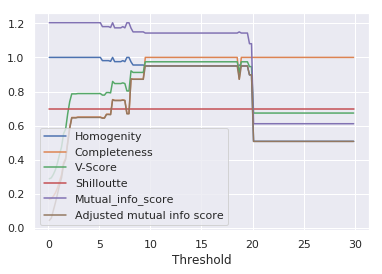

Highest V-cscore : 18.300000000000004


In [79]:
import matplotlib.pyplot as plt 

homogenity = []
completeness = []
vScore = []
shilloutte = []
f_score = []
mutualinfoscore =[]
adjustedmutualinfoscore = []

y = list(cluster_results.keys())
print("Threshold : ", list(y))
for val in cluster_results.items():
  homogenity+=[val[1][0]]
  completeness+=[val[1][1]]
  vScore+=[val[1][2]]
  shilloutte+=[val[1][3]]
  # f_score+=[val[1][4]]
  mutualinfoscore+=[val[1][4]]
  adjustedmutualinfoscore+=[val[1][5]]

# print("F1 Score : ", f_score)
print("Homogenity : ", homogenity)
print("Completeness : ", completeness)
print("V-Score : ", vScore)
print("Shilloutte", shilloutte)
print("Mutual info score", mutualinfoscore)
print("Adjusted mutual info score", adjustedmutualinfoscore)

# plt.plot(y,f_score, label = "F1 Score")
plt.plot(y,homogenity, label = "Homogenity")
plt.plot( y,completeness, label = "Completeness")
plt.plot( y,vScore, label = "V-Score")
plt.plot(y,shilloutte, label = "Shilloutte")
plt.plot(y,mutualinfoscore, label = "Mutual_info_score")
plt.plot(y,adjustedmutualinfoscore, label = "Adjusted mutual info score")

plt.xlabel('Threshold') 

plt.legend()

plt.show() 
print("Highest V-cscore :", y[vScore.index(max(vScore))])

**Write Clustering Results**

In [80]:
clustering_Results = {
        'Threshold': y,
        'Homogenity': homogenity,
        'Completeness': completeness,
        'vScore': vScore,
        'Shilloutte': shilloutte,
        'Mutual info score': mutualinfoscore,
        'Adjusted mutual info score': adjustedmutualinfoscore
    }

results = pd.DataFrame(clustering_Results)

results.to_csv(join_path(result_dir, experiment_dir, dataset + '_clustering_results.csv'))

**Get template**

In [81]:
def getTemplate(candidate):
    # candidate: list of list
    abstraction = ''

    # transpose row to column
    candidate_transpose = list(zip(*candidate))
    candidate_length = len(candidate)

    if candidate_length > 1:
        # get abstraction
        abstraction_list = []
        for index, message in enumerate(candidate_transpose):
            message_length = len(set(message))
            if message_length == 1:
                abstraction_list.append(message[0])
            else:
                abstraction_list.append('<*>')

        abstraction = ' '.join(abstraction_list)

    elif candidate_length == 1:
        abstraction = ' '.join(candidate[0])

    return abstraction

**Read Ground ruth templates**

In [82]:
import pandas as pd
df_raw_logs = pd.read_csv("/content/gdrive/My Drive/" + project_directory + "/Datasets_TB/ground_truth/"+ dataset + "/" + dataset +"_2k.log_structured.csv") 
raw_logs = df_raw_logs['Content'].to_numpy()

In [83]:
raw_logs

array(['workerEnv.init() ok /etc/httpd/conf/workers2.properties',
       'mod_jk child workerEnv in error state 6',
       'jk2_init() Found child 6725 in scoreboard slot 10', ...,
       'jk2_init() Found child 6790 in scoreboard slot 7',
       'workerEnv.init() ok /etc/httpd/conf/workers2.properties',
       'mod_jk child workerEnv in error state 6'], dtype=object)

**Get best clusterong based config**

In [84]:
len(raw_logs)

2000

In [85]:
predicted_labels = predicted_labels[y[vScore.index(max(vScore))]]
predicted_labels

array([0, 2, 1, ..., 1, 0, 2])

In [86]:
groups = pd.DataFrame()
groups['predicted_labels'] = predicted_labels
groups['raw_logs'] = raw_logs
groups

,predicted_labels,raw_logs
0,0,workerEnv.init() ok /etc/httpd/conf/workers2.p...
1,2,mod_jk child workerEnv in error state 6
2,1,jk2_init() Found child 6725 in scoreboard slot 10
3,1,jk2_init() Found child 6726 in scoreboard slot 8
4,1,jk2_init() Found child 6728 in scoreboard slot 6
...,...,...
1995,2,mod_jk child workerEnv in error state 6
1996,1,jk2_init() Found child 6791 in scoreboard slot 8
1997,1,jk2_init() Found child 6790 in scoreboard slot 7
1998,0,workerEnv.init() ok /etc/httpd/conf/workers2.p...


In [87]:
for i in np.unique(groups.predicted_labels):
  print(i)
  for index,row in groups.iterrows():
    if row['predicted_labels'] == i:
      print(row['raw_logs'])
  print('\n')


0
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.properties
workerEnv.init() ok /etc/httpd/conf/workers2.p

In [88]:
clusters = {}
for i in range(0, len(predicted_labels)):
    try:
        clusters[predicted_labels[i]].append(raw_logs[i].split(" "))
    except KeyError:
        clusters[predicted_labels[i]] = [raw_logs[i].split(" ")]


output = {}
# text_report = ''
for cluster in clusters.items():
  template = getTemplate(cluster[1])
  output['E' + str(cluster[0])] = template
  print(template)
  # text_report += template
  for log in cluster[1]:
    print(log)
    # text_report += str(log)
  print('\n')
  # text_report += '\n'

# with open(join_path(result_dir, experiment_dir, dataset + '_report.txt') ,'w') as report_file:
  # report_file.write(text_report)
  
    

def writeOutput(output):
    line = {
        'EventId': list(output.keys()),
        'EventTemplate': list(output.values())
    }

    df = pd.DataFrame(line)
    df.to_csv(join_path(result_dir, experiment_dir, dataset + '_templates.csv'))
  
  
writeOutput(output)

workerEnv.init() ok /etc/httpd/conf/workers2.properties
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()', 'ok', '/etc/httpd/conf/workers2.properties']
['workerEnv.init()',

In [89]:
structured_log = df_raw_logs.drop(['EventTemplate','EventId'], axis=1)
df_eventTemplates = pd.read_csv(join_path(result_dir, experiment_dir, dataset + '_templates.csv'))

In [90]:
template = []
eventId = []
 
for label in predicted_labels:
  template.append(df_eventTemplates[df_eventTemplates['EventId'] == 'E'+str(label)]['EventTemplate']) 
  eventId.append(df_eventTemplates[df_eventTemplates['EventId'] == 'E'+str(label)]['EventId'])

In [91]:
structured_log['EventId'] = eventId
structured_log['EventTemplate'] = template

In [92]:
structured_log.to_csv(join_path(result_dir, experiment_dir, dataset + '_structured.csv'))

In [93]:
def evaluate(groundtruth, parsedresult):
    
    df_groundtruth = pd.read_csv(groundtruth)
    df_parsedlog = pd.read_csv(parsedresult)

    # Remove invalid groundtruth event Templates
    null_logids = df_groundtruth[~df_groundtruth['EventTemplate'].isnull()].index
    df_groundtruth = df_groundtruth.loc[null_logids]
    df_parsedlog = df_parsedlog.loc[null_logids]

    (precision, recall, f_measure, accuracy) = get_accuracy(df_groundtruth['EventTemplate'], df_parsedlog['EventTemplate'])
    print('Precision: %.4f, Recall: %.4f, F1_measure: %.4f, Parsing_Accuracy: %.4f' % (
        precision, recall, f_measure, accuracy))
    return f_measure, accuracy


def get_accuracy(series_groundtruth, series_parsedlog, debug=False):
   
    series_groundtruth_valuecounts = series_groundtruth.value_counts()
    real_pairs = 0
    for count in series_groundtruth_valuecounts:
        if count > 1:
            real_pairs += scipy.special.comb(count, 2)

    series_parsedlog_valuecounts = series_parsedlog.value_counts()
    parsed_pairs = 0
    for count in series_parsedlog_valuecounts:
        if count > 1:
            parsed_pairs += scipy.special.comb(count, 2)

    accurate_pairs = 0
    accurate_events = 0  # determine how many lines are correctly parsed
    for parsed_eventId in series_parsedlog_valuecounts.index:
        logIds = series_parsedlog[series_parsedlog == parsed_eventId].index
        series_groundtruth_logId_valuecounts = series_groundtruth[logIds].value_counts()
        error_eventIds = (parsed_eventId, series_groundtruth_logId_valuecounts.index.tolist())
        error = True
        if series_groundtruth_logId_valuecounts.size == 1:
            groundtruth_eventId = series_groundtruth_logId_valuecounts.index[0]
            if logIds.size == series_groundtruth[series_groundtruth == groundtruth_eventId].size:
                accurate_events += logIds.size
                error = False
        if error and debug:
            print('(parsed_eventId, groundtruth_eventId) =', error_eventIds, 'failed', logIds.size, 'messages')
        for count in series_groundtruth_logId_valuecounts:
            if count > 1:
                accurate_pairs += scipy.special.comb(count, 2)

    precision = float(accurate_pairs) / parsed_pairs
    recall = float(accurate_pairs) / real_pairs
    f_measure = 2 * precision * recall / (precision + recall)
    accuracy = float(accurate_events) / series_groundtruth.size
    return precision, recall, f_measure, accuracy


In [94]:
print(evaluate("/content/gdrive/My Drive/" + project_directory + "/Datasets_TB/ground_truth/"+ dataset + "/" + dataset +"_2k.log_structured.csv",    #####path of the structured log csv of the groundtruth
               join_path(result_dir, experiment_dir, dataset + '_structured.csv')))

Precision: 0.9755, Recall: 1.0000, F1_measure: 0.9876, Parsing_Accuracy: 0.3005
(0.9875845566934288, 0.3005)


In [95]:
cd ..

/content/gdrive/My Drive/Vue4Logs


In [96]:
!cp -r Thaler2017/results/{dataset_number}_{dataset} /content/gdrive/My\ Drive/{project_directory}/our_experiments/{experiment_type}/{dataset}

In [97]:
!rm -r Thaler2017/results/{experiment_nr}_{dataset}
!rm -r Thaler2017/{experiment_nr}_{dataset}
!rm Thaler2017/data/{dataset}.*
!rm Thaler2017/data/test/{dataset}.log